# Gaussian Mixture with PCA

Because Guassian Mixture for this specific task was not as good as kmeans, I will not go through this code. But, it is essentially the exact same as kmeans dimension reduction but instead using Guassian Mixture.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture

df = pd.read_csv("/Users/giovanni-lunetta/stat_4185/final/past_ten_seasons/data/cleaned.csv")

In [2]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

X = df[['ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', '2P', '2PA', '3P', '3PA', 'FT', 'FTA', 'PTS', 'FG%', '2P%',
       '3P%', 'FT%', 'TS%', 'eFG%']]

# X = df[['ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', '2P', '2PA', '3P', '3PA', 'FT', 'FTA', 'PTS']]

# Create a StandardScaler object
scaler = StandardScaler()

# Apply the scaler to the selected variables
X_scaled = scaler.fit_transform(X)

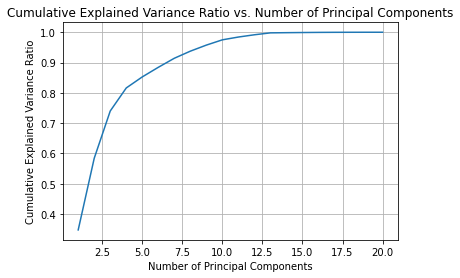

In [3]:
from sklearn.decomposition import PCA

# Perform PCA on the scaled data
pca = PCA().fit(X_scaled)

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Visualize the cumulative explained variance
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Principal Components')
plt.grid()
plt.show()

In [4]:
n_components = 3  # Choose the optimal number of components based on your analysis

# Create a PCA object with the optimal number of components
pca = PCA(n_components=n_components)

# Fit and transform the scaled data
X_pca = pca.fit_transform(X_scaled)

In [5]:
# # Split the PCA-transformed data into training and testing sets
# X_train_pca, X_test_pca = train_test_split(X_pca, test_size=0.3, random_state=42)

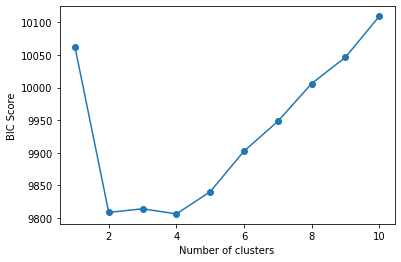

In [6]:
n_clusters = np.arange(1, 11)
bic_scores = []

for n in n_clusters:
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(X_pca)
    bic_scores.append(gmm.bic(X_pca))

plt.plot(n_clusters, bic_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('BIC Score')
plt.show()

# Find the optimal number of clusters
optimal_n_clusters = n_clusters[np.argmin(bic_scores)]

# optimal_n_clusters = n_clusters[4]

In [7]:
gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=42)
gmm.fit(X_pca)
# cluster_labels_train = gmm.predict(X_train_pca)

GaussianMixture(n_components=4, random_state=42)

In [8]:
# Get cluster labels for each observation
cluster_labels = gmm.predict(X_pca)

In [9]:
# Get cluster labels
cluster_labels = gmm.predict(X_pca)

# Add cluster labels to the PCA-transformed data
X_pca_clustered = np.column_stack((X_pca, cluster_labels))

# Convert the numpy array to a DataFrame
df_pca_clustered = pd.DataFrame(X_pca_clustered, columns=['PC1', 'PC2', 'PC3', 'Cluster'])

# Plot scatterplots for all clusters
centers_df = pd.DataFrame(gmm.means_, columns=['PC1', 'PC2', 'PC3'])
centers_df['Cluster'] = centers_df.index + 1

centers_melted = centers_df.melt(id_vars='Cluster', var_name='Feature', value_name='Value')

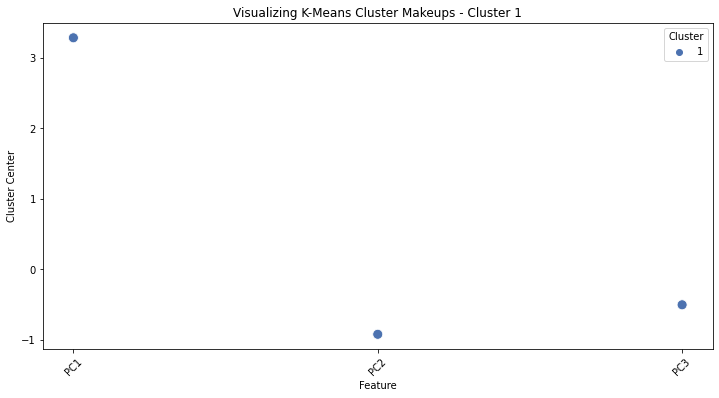

In [10]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(data=centers_melted[centers_melted['Cluster'] == 1], x='Feature', y='Value', hue='Cluster', palette='deep', s=100)
plt.xticks(rotation=45)
plt.title("Visualizing K-Means Cluster Makeups - Cluster 1")
plt.xlabel("Feature")
plt.ylabel("Cluster Center")
plt.legend(title='Cluster', loc='upper right')
plt.show()

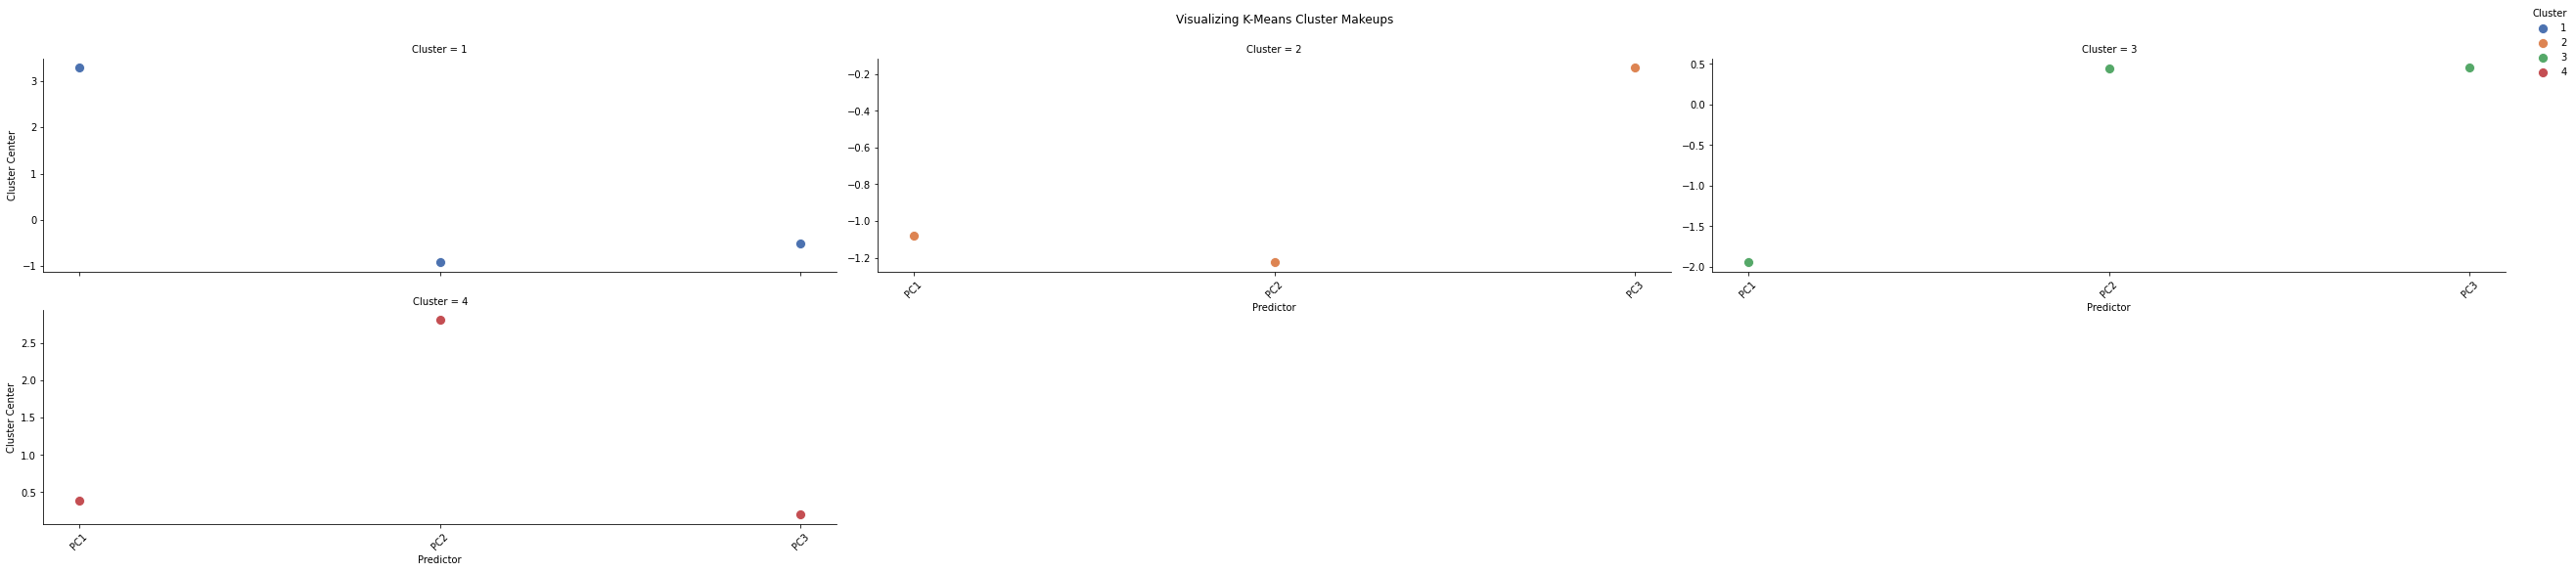

In [11]:
# Plot scatterplots for all clusters
g = sns.FacetGrid(centers_melted, col='Cluster', col_wrap=3, hue='Cluster', palette='deep', sharey=False, height=4, aspect=3)
g.map_dataframe(sns.scatterplot, x='Feature', y='Value', s=100)
g.set_xticklabels(rotation=45)

g.set_axis_labels("Predictor", "Cluster Center")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Visualizing K-Means Cluster Makeups")
g.add_legend(title='Cluster', loc='upper right')

plt.show()

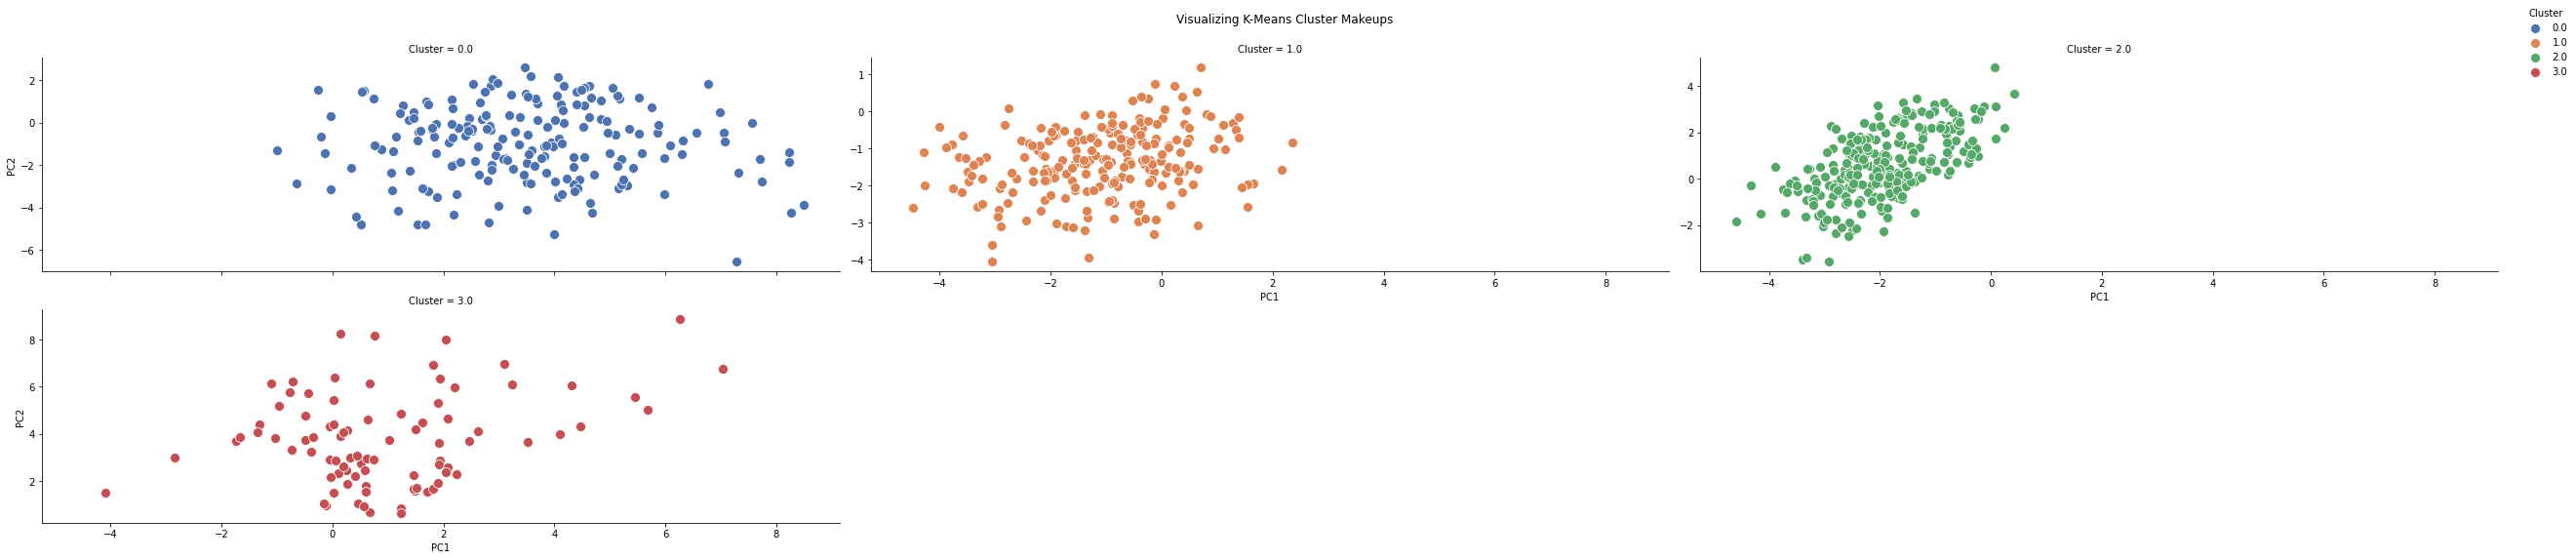

In [12]:
g = sns.FacetGrid(df_pca_clustered, col='Cluster', col_wrap=3, hue='Cluster', palette='deep', sharey=False, height=4, aspect=3)
g.map_dataframe(sns.scatterplot, x='PC1', y='PC2', s=100)
g.set_axis_labels("PC1", "PC2")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Visualizing K-Means Cluster Makeups")
g.add_legend(title='Cluster', loc='upper right')

plt.show()

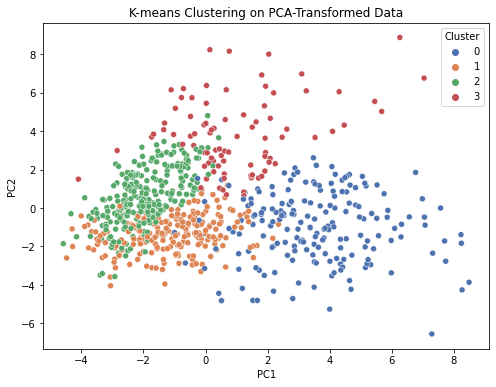

In [13]:
# Create a DataFrame with PCA components and cluster labels
pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(n_components)])
pca_df['Cluster'] = cluster_labels

# Create a scatter plot of the first two principal components, colored by cluster label
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='deep')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering on PCA-Transformed Data')
plt.show()

In [14]:
# Add cluster labels to the original DataFrame
df['Cluster (Gaussian_PCA)'] = cluster_labels

# View the players in each cluster
for i in range(optimal_n_clusters):
    print(f"Players in Cluster {i+1}:")
    print(df[df['Cluster (Gaussian_PCA)'] == i]['Player'].values)
    print()

Players in Cluster 1:
['Ivica Zubac' 'Ante Žižić' 'Tyler Zeller' 'Cody Zeller' 'Thaddeus Young'
 'Brandan Wright' 'Christian Wood' 'James Wiseman' 'Robert Williams'
 'Hassan Whiteside' 'David West' 'Trendon Watford' 'Gerald Wallace'
 'Nikola Vučević' 'Noah Vonleh' 'Jan Veselý' 'Anderson Varejão'
 'Jarred Vanderbilt' 'Jonas Valančiūnas' 'Ekpe Udoh' 'Myles Turner'
 'Ronny Turiaf' 'Xavier Tillman Sr.' 'Tristan Thompson' 'Jason Thompson'
 'Daniel Theis' 'Jared Sullinger' "Amar'e Stoudemire" 'Greg Stiemsma'
 'Isaiah Stewart' 'Tiago Splitter' 'Josh Smith' 'Jason Smith'
 'Jalen Smith' 'Greg Smith' 'Jericho Sims' 'Henry Sims' 'Ben Simmons'
 'Kevin Séraphin' 'Alperen Şengün' 'Luis Scola' 'Larry Sanders'
 'JaKarr Sampson' 'Robert Sacre' 'Domantas Sabonis' 'Thomas Robinson'
 'Mitchell Robinson' 'Andre Roberson' 'Nick Richards' 'Naz Reid'
 'Willie Reed' 'Zach Randolph' 'Ivan Rabb' 'Dwight Powell' 'Jakob Poeltl'
 'Miles Plumlee' 'Mason Plumlee' 'Kendrick Perkins' 'Nikola Peković'
 'Elfrid Payton' '

In [15]:
features = ['ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', '2P', '2PA', '3P', '3PA', 'FT', 'FTA', 'PTS', 'FG%', '2P%',
       '3P%', 'FT%', 'TS%', 'eFG%']

# features = ['ORB%', 'DRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', '2P', '2PA', '3P', '3PA', 'FT', 'FTA', 'PTS']

mean_values = df.groupby('Cluster (Gaussian_PCA)')[features].mean()

In [16]:
from math import pi

def create_radar_chart(mean_values, features, clusters):
    # Set the number of variables and calculate the angle for each axis
    num_vars = len(features)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]

    # Set the radar chart figure
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    # Set the first axis on top and move clockwise
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw axis lines and labels
    plt.xticks(angles[:-1], features)
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], color="gray", size=8)
    plt.ylim(0, 1)

    # Normalize the mean values to the range [0, 1]
    normalized_values = mean_values / mean_values.max().max()

    # Plot the radar chart for each cluster
    for i in range(clusters):
        values = normalized_values.iloc[i].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=f"Cluster {i}")
        ax.fill(angles, values, alpha=0.25)

    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Mean values by attribute for each cluster")
    plt.show()

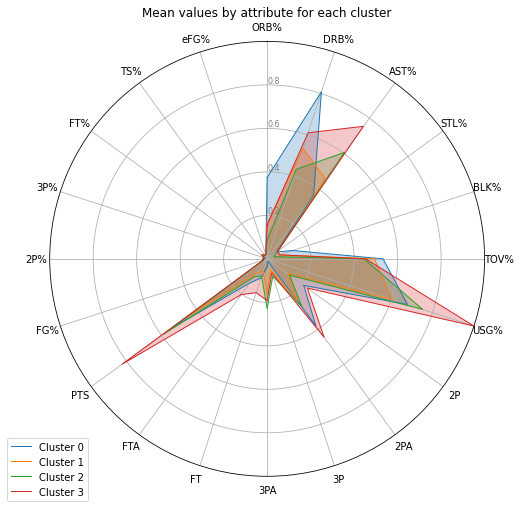

In [17]:
# Call the function to create the radar chart
create_radar_chart(mean_values, features, optimal_n_clusters)

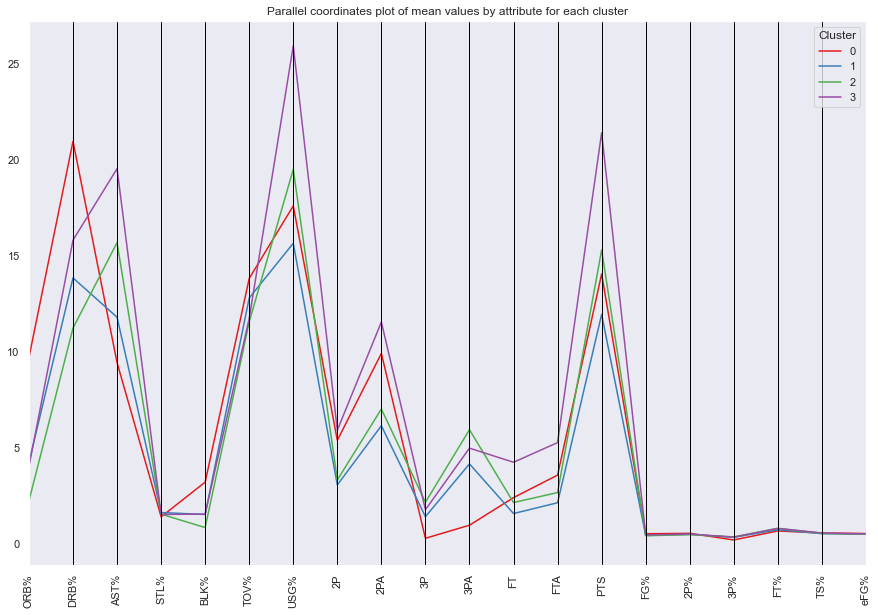

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

def create_parallel_coordinates_plot(mean_values, features, clusters):
    # Create a new DataFrame with the cluster labels and mean values
    mean_values['cluster'] = mean_values.index
    mean_values = mean_values.reset_index(drop=True)

    # Set up the plot
    plt.figure(figsize=(15, 10))

    # Plot the parallel coordinates plot using pd.plotting.parallel_coordinates()
    pd.plotting.parallel_coordinates(mean_values, 'cluster', color=plt.cm.Set1.colors)

    # Customize the plot
    plt.title("Parallel coordinates plot of mean values by attribute for each cluster")
    plt.xticks(range(len(features)), features, rotation=90)
    plt.legend(title='Cluster', loc='upper right')

create_parallel_coordinates_plot(mean_values, features, optimal_n_clusters)
plt.show()

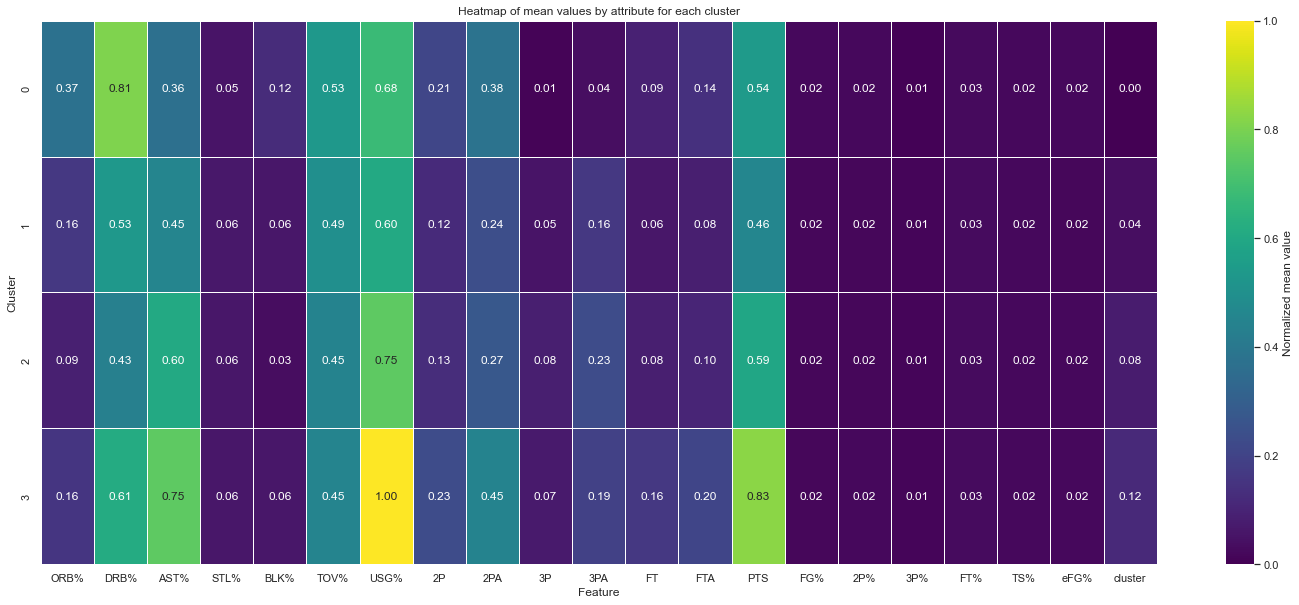

In [ ]:
def create_heatmap(mean_values, features, clusters):
    # Normalize the mean values to the range [0, 1]
    normalized_values = mean_values / mean_values.max().max()

    # Plot the heatmap
    plt.figure(figsize=(25, 10))
    sns.heatmap(normalized_values, cmap="viridis", annot=True, fmt=".2f", linewidths=.5, cbar_kws={'label': 'Normalized mean value'})
    plt.title("Heatmap of mean values by attribute for each cluster")
    plt.xlabel("Feature")
    plt.ylabel("Cluster")
    plt.show()

# Call the function to create the heatmap
create_heatmap(mean_values, features, optimal_n_clusters)

In [ ]:
import plotly.graph_objs as go

# Create a trace for the 3D scatter plot
scatter3d_trace = go.Scatter3d(
    x=X_pca[:, 0], y=X_pca[:, 1], z=X_pca[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=cluster_labels,
        colorscale='Viridis',
        opacity=0.8
    )
)

# Create a layout for the 3D scatter plot
scatter3d_layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='PC1'),
        yaxis=dict(title='PC2'),
        zaxis=dict(title='PC3')
    ),
)

# Combine the trace and layout into a Figure object
scatter3d_fig = go.Figure(data=[scatter3d_trace], layout=scatter3d_layout)

# Display the 3D scatter plot
scatter3d_fig.show()

Conclusions in README.